<a href="https://colab.research.google.com/github/AceAltair13/facial-expression-recognition/blob/main/VGG16_FER_2013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

SIZE_OF_CHUNK = 40960
DATA_SOURCE_MAPPING = 'fer2013:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F786787%2F1351797%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240514%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240514T063859Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8e5c763348de0790bbb7273845c616336e21a42a98c5904b3c6203b2a19d5747f2616afc4f4e82685b4f36b13da828b3d62d43de89fdbeb3aad271c2550c09d1cf75d211daf8f789dd1a8568d0272e9643593536fc1a164163fdf65749d236cd312c8b79668a89a96208bb0d8ee51cdc7fad13702afaa0713d21b1c33eb9f46495f65c222d5d388679205246739d7e46a8964a68d0645ca607bd1bd5f67f65322d755d29fdde062fdf8a8cc9c6b0590e74cd4492449184fa828abc2abff46e8d0df2e5ce61433941c88c08e30ea8ad4252591d7e285103180ca7701ac599d2ca789c7a34591b435f602e0510842b3075a59b154f6041297d35b900700c7be1fa'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(SIZE_OF_CHUNK)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(SIZE_OF_CHUNK)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 63252113 bytes downloaded
Downloaded and uncompressed: fer2013
Data source import complete.


# **VGG16**

A convolutional neural network architecture known for its simplicity and uniform architecture, consisting of 16 layers with trainable parameters. This model is designed for processing structured grid-like data, such as images. It consists of multiple layers, including convolutional, pooling, and fully connected layers. CNNs are highly effective for tasks like image classification, object detection, and image segmentation due to their hierarchical feature extraction capabilities.

### Dataset & Description

The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The training set consists of 28,709 examples and the public test set consists of 3,589 examples.

[Dataset link ](https://www.kaggle.com/msambare/fer2013)

### Importing Libraries and Modules

In this section, we import all the necessary libraries and modules required for our emotion recognition project.

- **Array and Dataframe Operations**: We use `numpy` and `pandas` for numerical operations and data manipulation respectively.
- **Visualization**: `matplotlib` and `seaborn` are used for creating plots and visualizations.
- **Image Reading**: `skimage.io` is used for reading images.
- **Keras and TensorFlow**: We use `keras` and `tensorflow` for creating and training our deep learning models. Specific modules for image preprocessing, model creation, and training are imported from these libraries.
- **Model Imports**: We import `VGG16` and `NASNetLarge` models from keras applications for our project.

In [2]:
# Importing necessary libraries for array and dataframe operations
import numpy as np
import pandas as pd

# Libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sn

# Library for reading images
import skimage.io

# Keras backend
import keras.backend as K

# TensorFlow library
import tensorflow as tf

# Importing necessary modules from TensorFlow for image preprocessing and model creation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model, Sequential

# Importing NASNetLarge model from Keras applications
from keras.applications.nasnet import NASNetLarge

# Importing necessary modules from TensorFlow for model training
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

### Data Preprocessing

In this section, we create ImageDataGenerator instances for training, validation, and testing datasets. These generators are used to apply real-time data augmentation. We rescale the images by 1./255 to normalize the pixel values (originally, pixel values range from 0 to 255). For the training data, we also apply a set of transformations to augment our dataset and improve generalization.

In [3]:
# Creating an ImageDataGenerator instance for the training data
training_data_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=5,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Creating an ImageDataGenerator instance for the validation data
validation_data_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Creating an ImageDataGenerator instance for the testing data
testing_data_generator = ImageDataGenerator(
    rescale=1./255
)

### Loading the Datasets

In this section, we load the training, validation, and testing datasets from their respective directories using the `flow_from_directory` method of our `ImageDataGenerator` instances. We set the target size of our images to be (48,48) and the class mode to 'categorical' for multi-class labels. We also specify the batch size to be 64.

In [4]:
# Loading the training dataset from the directory
training_dataset = training_data_generator.flow_from_directory(
    directory='../input/fer2013/train',
    target_size=(48, 48),
    class_mode='categorical',
    subset='training',
    batch_size=64
)

# Loading the validation dataset from the directory
validation_dataset = validation_data_generator.flow_from_directory(
    directory='../input/fer2013/train',
    target_size=(48, 48),
    class_mode='categorical',
    subset='validation',
    batch_size=64
)

# Loading the testing dataset from the directory
testing_dataset = testing_data_generator.flow_from_directory(
    directory='../input/fer2013/test',
    target_size=(48, 48),
    class_mode='categorical',
    batch_size=64
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Loading and Preprocessing Test Image

In the following code, we are loading a test image using Keras' `image` module. The image is resized to 48x48 pixels, which is the input size our model expects. We then display the image using `matplotlib.pyplot` and print its shape to confirm its dimensions.

Next, we add an extra dimension to the image array using `np.expand_dims` to match the input shape that our model expects. This is because our model expects to receive images in batches, even if we're only predicting for one image.

Finally, we load our trained model using `load_model` from Keras.

(48, 48, 3)
(1, 48, 48, 3)


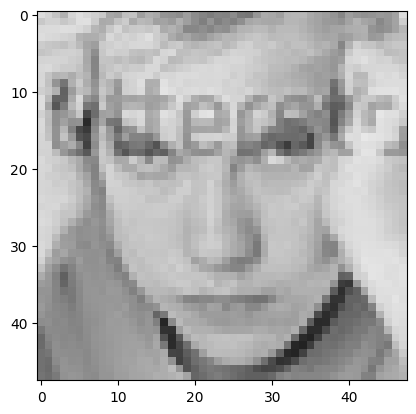

In [5]:
# Import necessary modules
from keras.preprocessing import image
from keras.models import load_model

# Load and resize the image
test_image = image.load_img("../input/fer2013/test/sad/PrivateTest_10814167.jpg", target_size = (48, 48))

# Convert the image to a numpy array
test_image_array = np.array(test_image)

# Display the image
plt.imshow(test_image_array)
print(test_image_array.shape)

# Add an extra dimension to match the model's input shape
test_image_array = np.expand_dims(test_image_array, axis = 0)
print(test_image_array.shape)

# Model Initialization

In this section, we initialize the VGG16 model with pre-trained weights from ImageNet. We set the input shape to be (48,48,3) and we do not include the top (output) layer as we will be adding our own output layer suitable for our problem.

In [6]:
# Initializing the VGG16 model with pre-trained weights from ImageNet
vgg16_base_model = tf.keras.applications.VGG16(
    input_shape=(48,48,3),
    include_top=False,
    weights="imagenet"
)

### Model Configuration

In this section, we configure our model. We start by freezing the layers of the base model (VGG16) except the last four. This is done to utilize the pre-trained weights from ImageNet. Then, we build our model by adding the base model and several other layers including Dropout for regularization, Flatten to flatten the output of the previous layer, BatchNormalization to normalize the activations of the previous layer, Dense for fully connected layers, and Activation for activation functions. Finally, we add our output layer with 7 neurons (for 7 classes) and 'softmax' activation function. We then print the summary of our model.

In [7]:
# Freezing Layers
for layer in vgg16_base_model.layers[:-4]:
    layer.trainable = False

# Building Model
emotion_recognition_model = Sequential()
emotion_recognition_model.add(vgg16_base_model)
emotion_recognition_model.add(Dropout(0.5))
emotion_recognition_model.add(Flatten())
emotion_recognition_model.add(BatchNormalization())
emotion_recognition_model.add(Dense(32, kernel_initializer='he_uniform'))
emotion_recognition_model.add(BatchNormalization())
emotion_recognition_model.add(Activation('relu'))
emotion_recognition_model.add(Dropout(0.5))
emotion_recognition_model.add(Dense(32, kernel_initializer='he_uniform'))
emotion_recognition_model.add(BatchNormalization())
emotion_recognition_model.add(Activation('relu'))
emotion_recognition_model.add(Dropout(0.5))
emotion_recognition_model.add(Dense(32, kernel_initializer='he_uniform'))
emotion_recognition_model.add(BatchNormalization())
emotion_recognition_model.add(Activation('relu'))
emotion_recognition_model.add(Dense(7, activation='softmax'))

# Model Summary
emotion_recognition_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 1, 1, 512)         0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 32)                16416     
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                       

### Model Visualization

In this section, we visualize our model architecture using the `plot_model` function from `tensorflow.keras.utils`. We set `show_shapes` and `show_layer_names` to True to display the shapes of the tensors on the edges of the nodes and the names of the layers in the graph. We save the plot to a file named 'convnet.png' and then display the image.

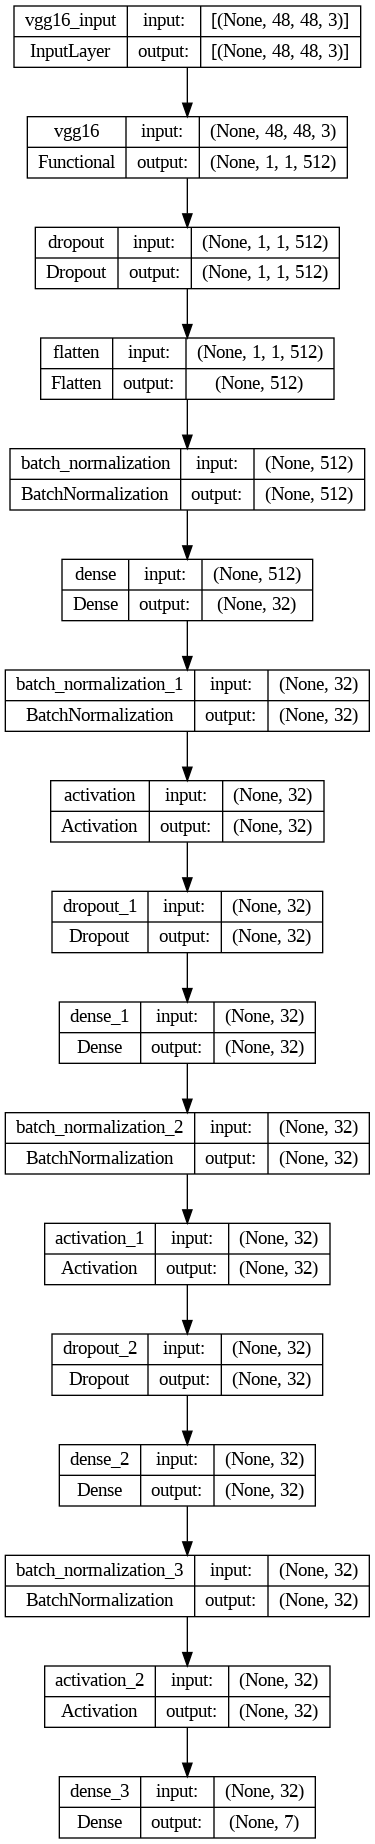

In [8]:
# Importing necessary modules for model visualization
from tensorflow.keras.utils import plot_model
from IPython.display import Image

# Plotting the model architecture and saving it to a file
plot_model(
    emotion_recognition_model,
    to_file='convnet.png',
    show_shapes=True,
    show_layer_names=True
)

# Displaying the image
Image(filename='convnet.png')

### F1 Score Function

In this section, we define a function to calculate the F1 score, which is a measure of a test's accuracy. The F1 score is the harmonic mean of precision and recall. We use the Keras backend (K) to perform the calculations. This function is taken from old Keras source code.

In [9]:
def f1_score(y_true, y_pred):
    # Calculating True Positives
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))

    # Calculating Possible Positives
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))

    # Calculating Predicted Positives
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

    # Calculating Precision
    precision = true_positives / (predicted_positives + K.epsilon())

    # Calculating Recall
    recall = true_positives / (possible_positives + K.epsilon())

    # Calculating F1 Score
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())

    return f1_val

### Defining the Metrics for Model Evaluation

In this section, we define a function to calculate the F1 score, which is a measure of a test's accuracy. The F1 score is the harmonic mean of precision and recall. We use the Keras backend (K) to perform the calculations. This function is taken from old Keras source code.

In [10]:
# Defining the metrics for model evaluation
evaluation_metrics = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

### Callbacks Configuration

In this section, we define the callbacks that we want to use during our model training. We use ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving, ModelCheckpoint to save the model after every epoch, and EarlyStopping to stop training when a monitored metric has stopped improving.

In [11]:
# Reduce learning rate when a metric has stopped improving
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.50,
    patience=20,
    verbose=1,
    min_lr=1e-10
)

# Save the model after every epoch
model_checkpoint = ModelCheckpoint(
    'model.h5'
)

# Stop training when a monitored metric has stopped improving
early_stopping = EarlyStopping(
    patience=20,
    verbose=1
)

# Model Compilation and Training

In this section, we compile our model by specifying the optimizer, loss function, and metrics. We use the Adam optimizer, categorical crossentropy as the loss function, and the metrics we defined earlier. Then, we train our model using the training dataset, with validation data, for a specified number of epochs. We also specify the callbacks we defined earlier.

In [12]:
# Compiling the model
emotion_recognition_model.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=evaluation_metrics
)

# Training the model
training_history = emotion_recognition_model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=5,
    verbose=1,
    callbacks=[learning_rate_reduction, model_checkpoint, early_stopping]
)

Epoch 1/5
359/359 [==============================] - ETA: 0s - loss: 1.9442 - accuracy: 0.8550 - precision: 0.2094 - recall: 0.0054 - auc: 0.5951 - f1_score: 0.0103

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


359/359 [==============================] - 82s 220ms/step - loss: 1.9442 - accuracy: 0.8550 - precision: 0.2094 - recall: 0.0054 - auc: 0.5951 - f1_score: 0.0103 - val_loss: 1.8414 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6437 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/5
359/359 [==============================] - 77s 214ms/step - loss: 1.8320 - accuracy: 0.8570 - precision: 0.2917 - recall: 9.1432e-04 - auc: 0.6378 - f1_score: 0.0018 - val_loss: 1.7969 - val_accuracy: 0.8573 - val_precision: 0.7857 - val_recall: 0.0019 - val_auc: 0.6582 - val_f1_score: 0.0038 - lr: 0.0010
Epoch 3/5
359/359 [==============================] - 76s 212ms/step - loss: 1.7922 - accuracy: 0.8573 - precision: 0.5466 - recall: 0.0074 - auc: 0.6652 - f1_score: 0.0144 - val_loss: 1.8275 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6483 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 4/5
359/359 [========================

# Plotting Training Results

In this section, we define a function to plot the training results. We plot five graphs for accuracy, loss, AUC (Area Under the ROC Curve), precision, and F1 score. Each graph shows the metric for both training and validation data across the epochs. We then call this function with the history of our model training.

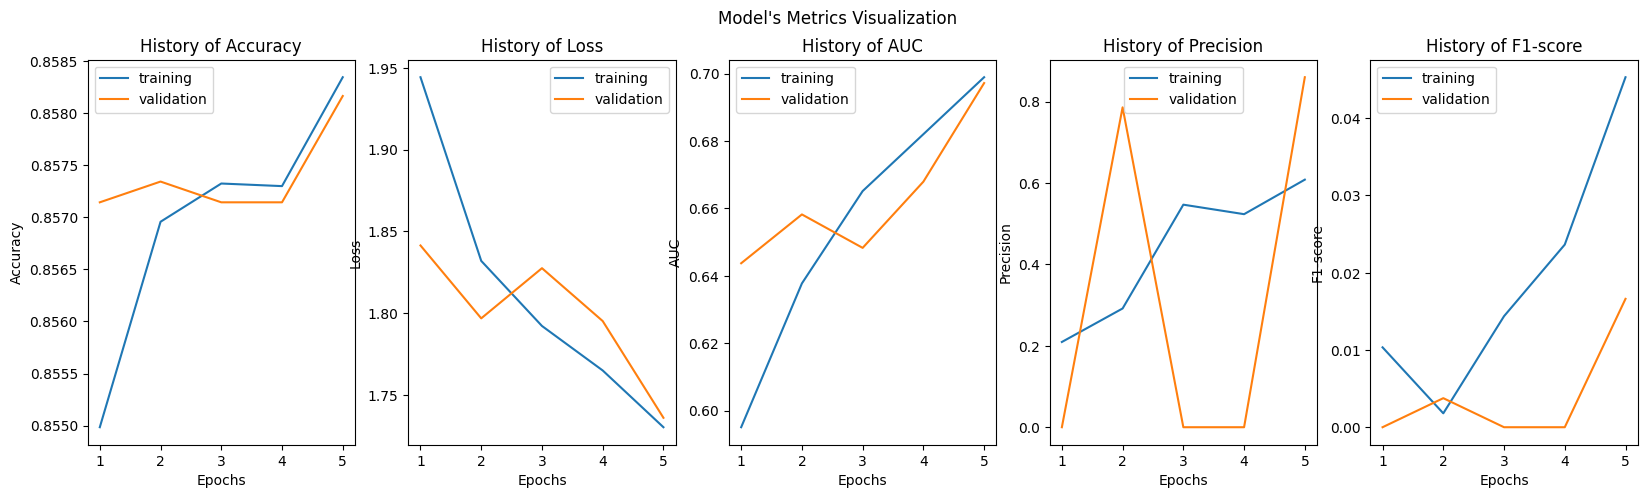

In [14]:
# Define a function to plot training and validation metrics
def plot_training_and_validation_metrics(training_accuracy, validation_accuracy, training_loss, validation_loss, training_auc, validation_auc, training_precision, validation_precision, training_f1, validation_f1):
    # Create a figure with 5 subplots for 5 metrics
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize = (20, 5))
    fig.suptitle("Model's Metrics Visualization")

    # Define a list of metrics to plot
    metrics = [
        (training_accuracy, validation_accuracy, 'Accuracy', ax1),
        (training_loss, validation_loss, 'Loss', ax2),
        (training_auc, validation_auc, 'AUC', ax3),
        (training_precision, validation_precision, 'Precision', ax4),
        (training_f1, validation_f1, 'F1-score', ax5),
    ]

    # Loop through the metrics list and plot each metric
    for training, validation, metric_name, ax in metrics:
        ax.plot(range(1, len(training) + 1), training)
        ax.plot(range(1, len(validation) + 1), validation)
        ax.set_title(f'History of {metric_name}')
        ax.set_xlabel('Epochs')
        ax.set_ylabel(metric_name)
        ax.legend(['training', 'validation'])

    # Display the plots
    plt.show()

# Call the function with the history of metrics from the model training process
plot_training_and_validation_metrics(
    training_history.history['accuracy'], training_history.history['val_accuracy'],
    training_history.history['loss'], training_history.history['val_loss'],
    training_history.history['auc'], training_history.history['val_auc'],
    training_history.history['precision'], training_history.history['val_precision'],
    training_history.history['f1_score'], training_history.history['val_f1_score']
)